In [1]:
from time import time
import numpy, os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import cv2

#Path to the root image directory containing sub-directories of images
path="dataset/"

data_slice = [70,195,78,172] # [ ymin, ymax, xmin, xmax]
# to extract the ‘interesting’ part of the image files 
# and avoid use statistical correlation from the background 

# resize ratio to reduce sample dimention
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio) #ymax - ymin slice, Height of image in float
w = int((data_slice[3] - data_slice[2])/resize_ratio) #xmax - xmin slice, Width of image in float 
print("Image dimension after resize (h,w) :", h, w)

n_sample = 0 #Initial sample count
label_count = 0 #Initial label count
n_classes = 0 #Initial class count

#PCA Component 
n_components = 7

Image dimension after resize (h,w) : 50 37


In [2]:
#Flat image Feature Vector
X=[]
#Int array of Label Vector
Y=[]

target_names = [] #Array to store the names of the persons

for directory in os.listdir(path):
    for file in os.listdir(path+directory):
        img=cv2.imread(path+directory+"/"+file)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        img=cv2.resize(img, (w,h))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        featurevector=numpy.array(img).flatten()
        X.append(featurevector)
        Y.append(label_count)
        n_sample = n_sample + 1
    target_names.append(directory)
    label_count=label_count+1


print("Samples :", n_sample)
print("Class :", target_names)
n_classes = len(target_names)

Samples : 100
Class : ['George_W_Bush', 'Khoi', 'Megawati_Sukarnoputri', 'Tiger_Woods']


In [3]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and teststing set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, len(X_train)))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("\n")
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 7 eigenfaces from 75 faces
done in 0.047s


Projecting the input data on the eigenfaces orthonormal basis
done in 0.002s


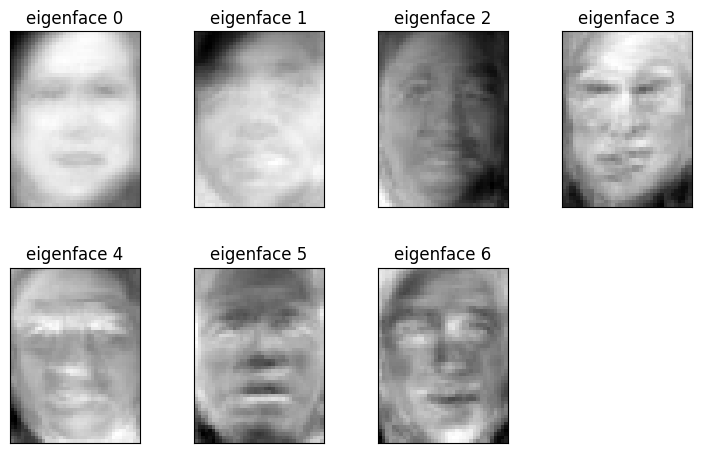

In [4]:
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_components):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)


In [5]:
###############################################################################
# Train a SVM classification model
print("\n")
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

print("\n")
print("Best estimator found by grid search : ")
print(clf.best_estimator_)

###############################################################################
# Quantitative evaluation of the model quality on the test set
print("\n")
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca,y_test))
print("done in %0.3fs" % (time() - t0))

print("\nClassification Report : ")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))




Fitting the classifier to the training set
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ............C=1000.0, gamma=0.0001;, score=0.733 total time=   0.0s
[CV 2/5] END ............C=1000.0, gamma=0.0001;, score=0.867 total time=   0.0s
[CV 3/5] END ............C=1000.0, gamma=0.0001;, score=0.867 total time=   0.0s
[CV 4/5] END ............C=1000.0, gamma=0.0001;, score=0.733 total time=   0.0s
[CV 5/5] END ............C=1000.0, gamma=0.0001;, score=0.933 total time=   0.0s
[CV 1/5] END ............C=1000.0, gamma=0.0005;, score=0.800 total time=   0.0s
[CV 2/5] END ............C=1000.0, gamma=0.0005;, score=0.867 total time=   0.0s
[CV 3/5] END ............C=1000.0, gamma=0.0005;, score=0.867 total time=   0.0s
[CV 4/5] END ............C=1000.0, gamma=0.0005;, score=0.667 total time=   0.0s
[CV 5/5] END ............C=1000.0, gamma=0.0005;, score=1.000 total time=   0.0s
[CV 1/5] END .............C=1000.0, gamma=0.001;, score=0.867 total time=   0.0s
[C

[CV 3/5] END ..............C=50000.0, gamma=0.1;, score=0.867 total time=   0.0s
[CV 4/5] END ..............C=50000.0, gamma=0.1;, score=0.667 total time=   0.0s
[CV 5/5] END ..............C=50000.0, gamma=0.1;, score=0.933 total time=   0.0s
[CV 1/5] END ..........C=100000.0, gamma=0.0001;, score=0.867 total time=   0.0s
[CV 2/5] END ..........C=100000.0, gamma=0.0001;, score=0.867 total time=   0.0s
[CV 3/5] END ..........C=100000.0, gamma=0.0001;, score=0.867 total time=   0.0s
[CV 4/5] END ..........C=100000.0, gamma=0.0001;, score=0.600 total time=   0.0s
[CV 5/5] END ..........C=100000.0, gamma=0.0001;, score=1.000 total time=   0.0s
[CV 1/5] END ..........C=100000.0, gamma=0.0005;, score=0.867 total time=   0.0s
[CV 2/5] END ..........C=100000.0, gamma=0.0005;, score=0.867 total time=   0.0s
[CV 3/5] END ..........C=100000.0, gamma=0.0005;, score=0.867 total time=   0.0s
[CV 4/5] END ..........C=100000.0, gamma=0.0005;, score=0.533 total time=   0.0s
[CV 5/5] END ..........C=100

In [6]:
###############################################################################
# Prediction of user based on the model

test = []
#testImage = "test/Tiger_Woods_0010.jpg"
testImage = "test/Tiger_Woods_0022.jpg"


testImage=cv2.imread(testImage)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
testImage=cv2.resize(testImage, (w,h))
testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
testImageFeatureVector=numpy.array(testImage).flatten()
test.append(testImageFeatureVector)
testImagePCA = pca.transform(test)
testImagePredict=clf.predict(testImagePCA)


print ("Predicted Name : " + target_names[testImagePredict[0]])


Predicted Name : Tiger_Woods


In [7]:
path_testdata = "test/"
for file in os.listdir(path_testdata):
    test = []

    filename=path_testdata + file    
    testImage=cv2.imread(filename)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
    testImage=cv2.resize(testImage, (w,h))
    testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
    testImageFeatureVector=numpy.array(testImage).flatten()
    
    test.append(testImageFeatureVector)
    testImagePCA = pca.transform(test)
    testImagePredict=clf.predict(testImagePCA)

    print ("File Source : " + filename)
    print ("Predicted Name : " + target_names[testImagePredict[0]] + "\n")

File Source : test/George_W_Bush_0037.jpg
Predicted Name : George_W_Bush

File Source : test/George_W_Bush_0526.jpg
Predicted Name : George_W_Bush

File Source : test/khoi_0.jpg
Predicted Name : Khoi

File Source : test/khoi_1.jpg
Predicted Name : Khoi

File Source : test/khoi_2.jpg
Predicted Name : Khoi

File Source : test/khoi_3.jpg
Predicted Name : Khoi

File Source : test/Megawati_Sukarnoputri_0021.jpg
Predicted Name : Megawati_Sukarnoputri

File Source : test/Megawati_Sukarnoputri_0022.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Sukarnoputri_0023.jpg
Predicted Name : Megawati_Sukarnoputri

File Source : test/Megawati_Sukarnoputri_0024.jpg
Predicted Name : Megawati_Sukarnoputri

File Source : test/Megawati_Sukarnoputri_0025.jpg
Predicted Name : Megawati_Sukarnoputri

File Source : test/Megawati_Sukarnoputri_0026.jpg
Predicted Name : Megawati_Sukarnoputri

File Source : test/Megawati_Sukarnoputri_0027.jpg
Predicted Name : Tiger_Woods

File Source : test/Megawati_Su

In [8]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

cap.set(3,640)
cap.set(4,480)

while(True):
    # Capture frame-by-frame
    test = []
    face = []
    ret, frame = cap.read()
    xv, yv, cv = frame.shape
    if ret == True :
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,wf,hf) in faces:
            cy, cx = y + (hf//2), x + (wf//2)
            max_len = max(max(hf//2,wf//2), 125)
            
            if (x - max_len) <= 0 or (x + max_len) >= xv or (y - max_len) <= 0 or (y + max_len) >= yv :
                continue
            face_crop = (frame[cy-max_len:cy+max_len, cx-max_len:cx+max_len])
            face_crop = face_crop[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
            
            testImage = cv2.resize(face_crop, (w,h))
            cv2.imshow('face',testImage)
            
            testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
            testImageFeatureVector=numpy.array(testImage).flatten()
            test.append(testImageFeatureVector)
            testImagePCA = pca.transform(test)
            testImagePredict=clf.predict(testImagePCA)
            
            # create box on detected face
            frame = cv2.rectangle(frame,(x,y),(x+wf,y+hf),(255,0,0),1)
            frame = cv2.rectangle(frame,(x,y+hf),(x+wf,y+hf+30),(255,0,0),-1)
            # print label name on image
            cv2.putText(frame, "Name : " + target_names[testImagePredict[0]], (x + x//10, y+hf+20), \
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        cv2.imshow('frame',frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()